In [1]:
# This example runs multiple sorters in parallel using a local computer
# Created by James Jun on Mar 27, 2019

# prerequisits
# $ pip install ml_ms4alg
# $ conda install -c conda-forge ipywidgets
# $ jupyter labextension install @jupyter-widgets/jupyterlab-manager

# please ignore the warning when running MountainSort4
#   RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import spikeforest_analysis as sa
import spikeextractors as se
import os, shutil, datetime, json, numpy as np, pandas as pd, json, datetime
import sfdata as sf
from spikesorters import IronClust, MountainSort4, KiloSort, KiloSort2
from spikeforest import spikewidgets as sw
import ipywidgets as widgets
from spikeforest_analysis.compare_sortings_with_truth import GenSortingComparisonTable
from spikeforest_analysis.compute_units_info import ComputeUnitsInfo
from matplotlib import pyplot as plt
import mlprocessors as mlpr
from mlprocessors import LocalComputeResource

In [5]:
# Define sorters
# run `createJob` instead of `execute` for delayed execution

f_force_run = True
adjacency_radius = 100

def irc_static(recpath, firings_out):
    return IronClust.createJob(
            recording_dir=recpath,
            firings_out=firings_out,
            detect_sign=-1,
            adjacency_radius=adjacency_radius,
            prm_template_name='static',
            _force_run=f_force_run)

def irc_drift(recpath, firings_out):
    return IronClust.createJob(
            recording_dir=recpath,
            firings_out=firings_out,
            detect_sign=-1,
            adjacency_radius=adjacency_radius,
            prm_template_name='drift',
            _force_run=f_force_run)

def ms4(recpath, firings_out):
    return MountainSort4.createJob(
            recording_dir=recpath,
            firings_out=firings_out,
            detect_sign=-1,
            adjacency_radius=adjacency_radius,
            _force_run=f_force_run)

def ksort(recpath, firings_out):
    return KiloSort.createJob(
            recording_dir=recpath,
            firings_out=firings_out,
            detect_sign=-1,
            adjacency_radius=adjacency_radius,
            _force_run=f_force_run)

def ksort2(recpath, firings_out):
    return KiloSort2.createJob(
            recording_dir=recpath,
            firings_out=firings_out,
            detect_sign=-1,
            adjacency_radius=adjacency_radius,
            _force_run=f_force_run)

#D_sorters = dict(KiloSort=ksort, IronClust_static=irc, MountainSort4=ms4, KiloSort2=ksort2, IronClust_drift=irc_drift)
D_sorters = dict(KiloSort=ksort, IronClust_static=irc_static, MountainSort4=ms4)

In [6]:
# select a data source and sorter
# you may change the data source index and sorter index
LS_sorter = list(D_sorters.keys())
LS_sorter.insert(0,'all')

widget1 = widgets.Dropdown(
    options=LS_sorter, index=0, description='Spike sorters')
display(widget1)

LS_datasource = ['generate locally', 'download']
widget2 = widgets.Dropdown(
    options = LS_datasource, index=0, description='Data source')
display(widget2)

Dropdown(description='Spike sorters', options=('all', 'KiloSort', 'IronClust_static', 'MountainSort4'), value=…

Dropdown(description='Data source', options=('generate locally', 'download'), value='generate locally')

In [7]:
# create a parameters dictionary
D_params = dict(
    datasource = LS_datasource[widget2.index],
    path_in = 'recordings/example1',
    path_out = 'sortings/example1',
    )

S_sorter = LS_sorter[widget1.index]
if S_sorter == 'all':
    D_params['sorter'] = LS_sorter[1:]
    
else:
    D_params['sorter'] = [S_sorter]
    

In [8]:
# get recording
path_in = D_params['path_in']
# delete previous recording
#  os.path.exists(recpath): shutil.rmtree(recpath)
# delete previous output and make save
path_in_true = os.path.join(path_in, 'firings_true.mda')
path_in_json = os.path.join(path_in, 'units_info.json')

if D_params['datasource'] == 'generate locally':
    print(path_in_true)
    if not os.path.exists(path_in_true):
        # generate recording
        rx, sx_true = se.example_datasets.toy_example1(
            duration=600, num_channels=4, samplerate=30000, K=10)
        print('Generated recording in ' + path_in)
    else:
        rx = se.MdaRecordingExtractor(path_in)
        sx_true = se.MdaSortingExtractor(path_in_true)
        print('Using cached recording in ' + path_in)
else:
    # download recording
    #kpath = 'kbucket://15734439d8cf/groundtruth/magland_synth/datasets_noise10_K10_C4/001_synth'
    #kpath = '/mnt/home/jjun/ceph/groundtruth/hybrid_drift/rec_32c_600s_11'
    kpath = '/mnt/home/jjun/ceph/groundtruth/hybrid_drift/rec_64c_1200s_11'
    rx = se.MdaRecordingExtractor(kpath, download=True)
    sx_true = se.MdaSortingExtractor(kpath + '/firings_true.mda')   
    
if not os.path.exists(path_in): 
    os.makedirs(path_in)
    se.MdaRecordingExtractor.write_recording(recording=rx, save_path=path_in)
    se.MdaSortingExtractor.write_sorting(
        sorting=sx_true, save_path=path_in_true)
        
# summarize recording
if not os.path.exists(path_in_json):
    ComputeUnitsInfo.execute(
        recording_dir = path_in,
        firings = path_in_true,
        json_out = path_in_json,
        )
with open(path_in_json) as f:
    snr_json = json.load(f)
    unit_snrs = [x['snr'] for x in snr_json]
    unit_ids = [x['unit_id'] for x in snr_json]
    sx_true.setUnitsProperty(property_name='snr', 
         values=unit_snrs, unit_ids=unit_ids)


recordings/example1/firings_true.mda
Using cached recording in recordings/example1


In [11]:
t1 = datetime.datetime.now()

# Schedule spike sorting tasks
path_in = D_params['path_in']
path_out = D_params['path_out']
L_jobs_sorting = list()
for S_sorter1 in D_params['sorter']:
    # check if the sorting is done already
    path_out1 = os.path.join(path_out, S_sorter1)
    if not os.path.exists(path_out1): 
        os.makedirs(path_out1)  
    path_out_firings1 = os.path.join(path_out1, 'firings_out.mda')
    if not os.path.exists(path_out_firings1):
        print('Running '+ S_sorter1 + ' in notebook.')
        L_jobs_sorting.append(D_sorters[S_sorter1](path_in, path_out_firings1))   
        
# Run sorting jobs
with LocalComputeResource(num_parallel=4) as compute_resource:
    mlpr.executeBatch(jobs=L_jobs_sorting, compute_resource=compute_resource)
        
# Collect results and run validation
L_jobs_comparison = list()
for S_sorter1 in D_params['sorter']:
    path_out1 = os.path.join(path_out, S_sorter1)
    path_out_firings1 = os.path.join(path_out1, 'firings_out.mda')
    sx1 = se.MdaSortingExtractor(path_out_firings1)
    print('Loaded '+ S_sorter1 + ' from ' + path_out_firings1)
    
    # validation           
    path_out_json1 = os.path.join(path_out1, 'sorting_comparison.json')
    if not os.path.exists(path_out_json1):
        print('Computing comparison...')
        job1 = GenSortingComparisonTable.createJob(
            firings = path_out_firings1,
            units_true = None,
            firings_true = os.path.join(path_in, 'firings_true.mda'),
            json_out = path_out_json1,
            html_out = os.path.join(path_out1, 'sorting_comparison.html'),
            )
        L_jobs_comparison.append(job1)

# Run comparison jobs
with LocalComputeResource(num_parallel=4) as compute_resource:
    mlpr.executeBatch(jobs=L_jobs_comparison, compute_resource=compute_resource)

# assemble comparison objects
LD_comparison = list()
for S_sorter1 in D_params['sorter']:
    path_out1 = os.path.join(path_out, S_sorter1)
    path_out_json1 = os.path.join(path_out1, 'sorting_comparison.json')
    df1 = pd.read_json(path_or_buf=path_out_json1)    
    L_unit_id = [int(x) for x in df1.transpose()['unit_id'].to_list()]
    L_accuracy = df1.transpose()['accuracy'].to_list()
    L_snr = sx_true.getUnitsProperty(unit_ids=L_unit_id, property_name='snr')
    L_recall = [1-x for x in df1.transpose()['f_n'].to_list()]
    L_precision = [1-x for x in df1.transpose()['f_p'].to_list()]
    D_comparison1 = dict(
        L_snr = L_snr, S_sorter=S_sorter1, 
        L_accuracy = L_accuracy, L_recall = L_recall, L_precision = L_precision)
    LD_comparison.append(D_comparison1)
    
dt = datetime.datetime.now() - t1
print('took {:0.3f}s'.format(dt.total_seconds()))

Stopping local compute resource
MOUNTAIN CONFIG: local database; local sha-1 cache
registering compute resource:  local_resource_fOliGf
local_resource_fOliGf: Starting compute resource: local_resource_fOliGf
Exiting compute resource...
.
Loaded KiloSort from sortings/example1/KiloSort/firings_out.mda
Loaded IronClust_static from sortings/example1/IronClust_static/firings_out.mda
Loaded MountainSort4 from sortings/example1/MountainSort4/firings_out.mda
MOUNTAIN CONFIG: local database; local sha-1 cache
registering compute resource:  local_resource_yysZBT
local_resource_yysZBT: Starting compute resource: local_resource_yysZBT
Exiting compute resource...
Stopping local compute resource
.
took 0.572s


KiloSort


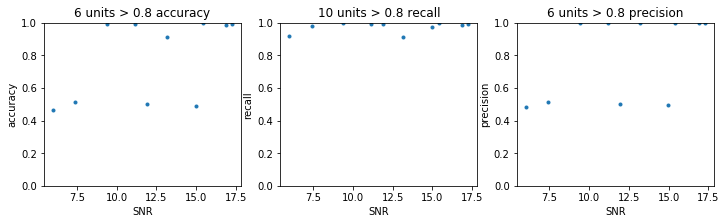

IronClust_static


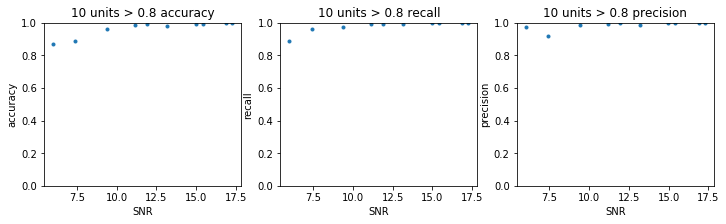

MountainSort4


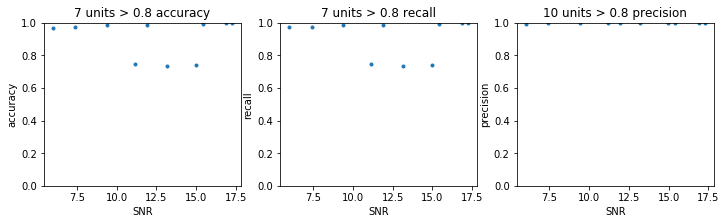

In [10]:
# plot SNR vs accuracy for the first sorting output
accuracy_thresh, snr_thresh = .8, 8

#LD_comparison1 = [LD_comparison[i] for i in [3,1,4,0,2]]
LD_comparison1 = LD_comparison
for D_comparison1 in LD_comparison1:
    fig=plt.figure(figsize=(12,3))
    L_accuracy1 = D_comparison1['L_accuracy']
    L_recall1 = D_comparison1['L_recall']
    L_precision1 = D_comparison1['L_precision']
    L_snr1 = D_comparison1['L_snr']
    S_sorter1 = D_comparison1['S_sorter']
    
    print(S_sorter1)
    ax=fig.add_subplot(1,3,1)
    ax.plot(L_snr, L_accuracy1, '.')
    plt.xlabel('SNR')
    plt.ylabel('accuracy')    
    plt.ylim(0,1)
    nUnits_above = np.sum(np.array(L_accuracy1) >= accuracy_thresh)
    plt.title('{} units > {} accuracy'.format(nUnits_above, accuracy_thresh))  
    
    ax=fig.add_subplot(1,3,2)
    ax.plot(L_snr, L_recall1, '.')
    plt.xlabel('SNR')
    plt.ylabel('recall')    
    plt.ylim(0,1)
    nUnits_above = np.sum(np.array(L_recall1) >= accuracy_thresh)
    plt.title('{} units > {} recall'.format(nUnits_above, accuracy_thresh))  
    
    ax=fig.add_subplot(1,3,3)
    ax.plot(L_snr, L_precision1, '.')
    plt.xlabel('SNR')
    plt.ylabel('precision')    
    plt.ylim(0,1)
    nUnits_above = np.sum(np.array(L_precision1) >= accuracy_thresh)
    plt.title('{} units > {} precision'.format(nUnits_above, accuracy_thresh))  
    
    plt.show()
